# Cats VS Dogs

![](https://kaggle2.blob.core.windows.net/competitions/kaggle/3362/media/woof_meow.jpg)

> In this competition, you'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.

Find more info at [Kaggle.com](https://www.kaggle.com/c/dogs-vs-cats).

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Using cached Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 5.0.0
    Uninstalling Pillow-5.0.0:
      Successfully uninstalled Pillow-5.0.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn import metrics

In [0]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

EPOCHS_TO_TRAIN = 10

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 8

In [7]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [8]:
!wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data/

--2018-02-08 15:51:50--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip.1’

dogscats.zip.1      100%[===================>] 817.50M  30.3MB/s    in 32s     

2018-02-08 15:52:21 (25.8 MB/s) - ‘dogscats.zip.1’ saved [857214334/857214334]

Archive:  dogscats.zip
replace data/dogscats/sample/train/cats/cat.2921.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Data loading

In [0]:
PATH = "data/dogscats/"

In [8]:
!ls {PATH}/

models	sample	test1  train  valid


In [9]:
!ls {PATH}valid

cats  dogs


In [10]:
files = !ls {PATH}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

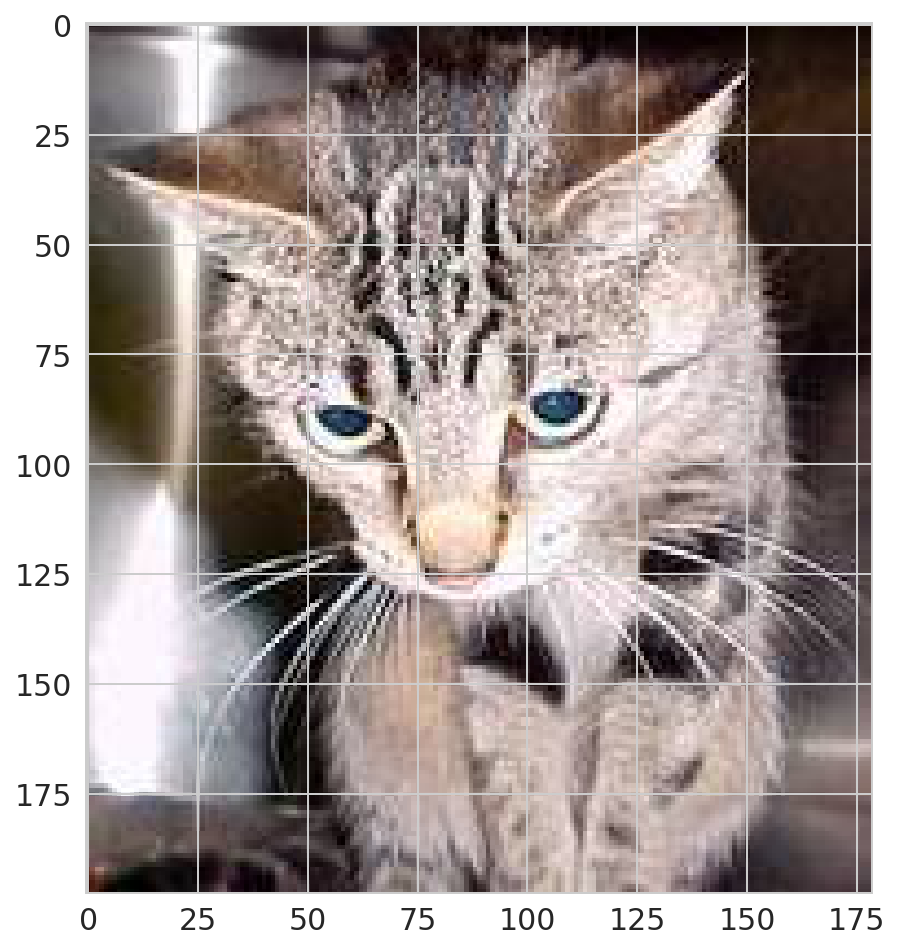

In [11]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [12]:
img.shape

(198, 179, 3)

# Data transformation

In [0]:
import torch.utils.data as data
import torchvision.datasets as datasets
import os

traindir = PATH + "train"
testdir = PATH + "valid"

train_loader = data.DataLoader(
        datasets.ImageFolder(traindir,
                             transforms.Compose([
                                 transforms.Resize(70),
                                 transforms.CenterCrop(64),
                                 transforms.ToTensor()
                             ])),
        batch_size=64,
        shuffle=True,
        pin_memory=True)

test_loader = data.DataLoader(
        datasets.ImageFolder(testdir,
                        transforms.Compose([
                            transforms.Resize(70),
                            transforms.CenterCrop(64),
                            transforms.ToTensor()
                        ])),
        batch_size=64,
        shuffle=False,
        pin_memory=False)

In [14]:
len(train_loader.dataset.imgs)

23000

In [15]:
len(test_loader.dataset.imgs)

2000

In [0]:
batch = next(iter(train_loader))

In [0]:
X, y = batch

In [18]:
X[0].shape

torch.Size([3, 64, 64])

In [0]:
def show_image(tensor_data):
  im = tensor_data.numpy()
  im = np.transpose(im, (1,2,0))
  plt.imshow(im)
  plt.show();

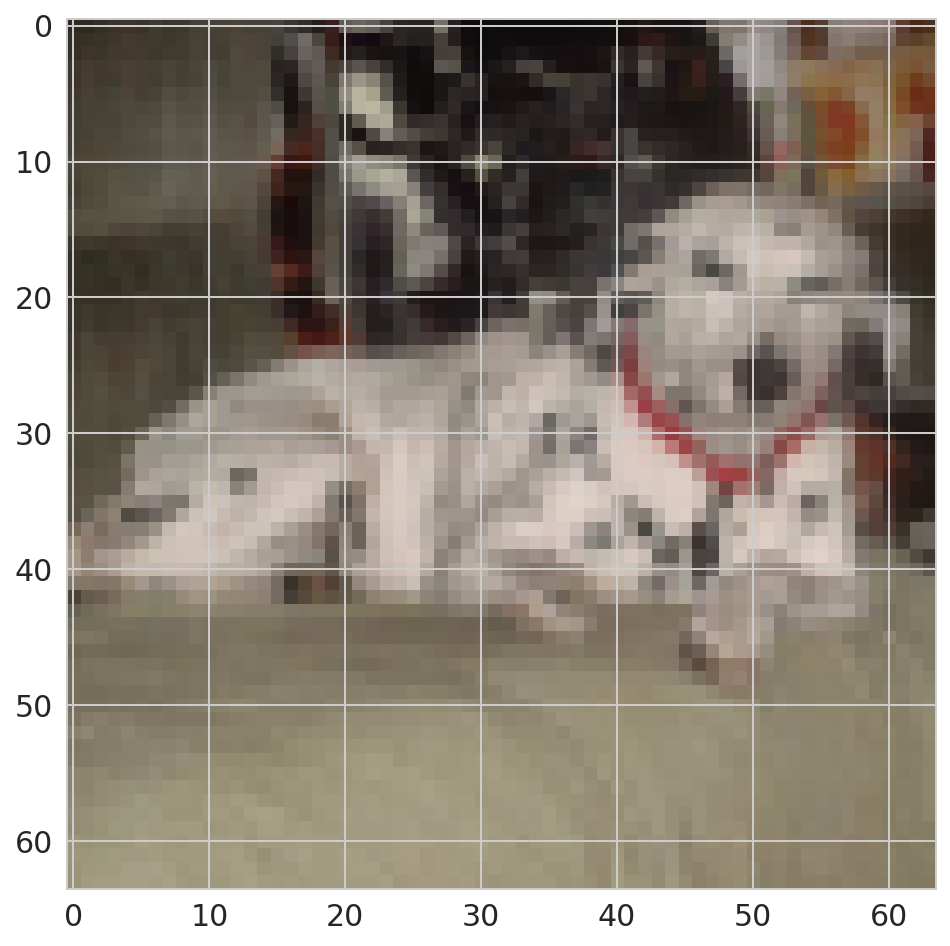

In [20]:
show_image(X[0])

In [21]:
y[0]

1

# Model

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        self.fc1 = nn.Linear(20 * 6 * 6, 100)
        self.fc1_drop = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        c1 = self.conv1(x)
        x = F.relu(self.pool1(c1))
        c2 = self.conv2(x)
        x = F.relu(self.pool2(c2))
        x = x.view(-1, 20 * 6 * 6)
        x = self.fc1_drop(F.relu(self.fc1(x)))
        return self.fc2(x)

In [0]:
model = CNN()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    criterion = criterion.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [76]:
model

CNN(
  (conv1): Conv2d (3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), dilation=(1, 1))
  (conv2): Conv2d (10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), dilation=(1, 1))
  (fc1): Linear(in_features=720, out_features=100)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=100, out_features=2)
)

In [77]:
train_loss = []
test_loss = []


for epoch in range(EPOCHS_TO_TRAIN):
    model.train()
    e_train_loss = []
    for data, target in train_loader:
     
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()

        y_pred = model(data)

        loss = criterion(y_pred, target)
        e_train_loss.append(loss.data[0])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
    mean_train_loss = np.mean(e_train_loss)
    train_loss.append(mean_train_loss)
        
    model.eval()
    e_test_loss = []
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target, volatile=True)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        

        
        loss = criterion(output, target).data[0]
        e_test_loss.append(loss)
        
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    mean_test_loss = np.mean(e_test_loss)
    test_loss.append(mean_test_loss)
    
    print(f"""
    ######### Epoch {epoch + 1} #########\n
    average train loss: {mean_train_loss}
    average test loss: {mean_test_loss}
    test accuracy: {correct}/{len(test_loader.dataset)} {100. * correct / len(test_loader.dataset)}%
""")


    ######### Epoch 1 #########

    average train loss: 0.6376743924286631
    average test loss: 0.5768812550231814
    test accuracy: 1404/2000 70.2%


    ######### Epoch 2 #########

    average train loss: 0.5506249237391684
    average test loss: 0.5361568862572312
    test accuracy: 1474/2000 73.7%


    ######### Epoch 3 #########

    average train loss: 0.5101590510043833
    average test loss: 0.49920689314603806
    test accuracy: 1511/2000 75.55%


    ######### Epoch 4 #########

    average train loss: 0.4820535029802058
    average test loss: 0.5253305938094854
    test accuracy: 1452/2000 72.6%


    ######### Epoch 5 #########

    average train loss: 0.46698644931117694
    average test loss: 0.4715295862406492
    test accuracy: 1550/2000 77.5%


    ######### Epoch 6 #########

    average train loss: 0.44752559181716706
    average test loss: 0.4660502662882209
    test accuracy: 1557/2000 77.85%


    ######### Epoch 7 #########

    average train loss: 0.43238

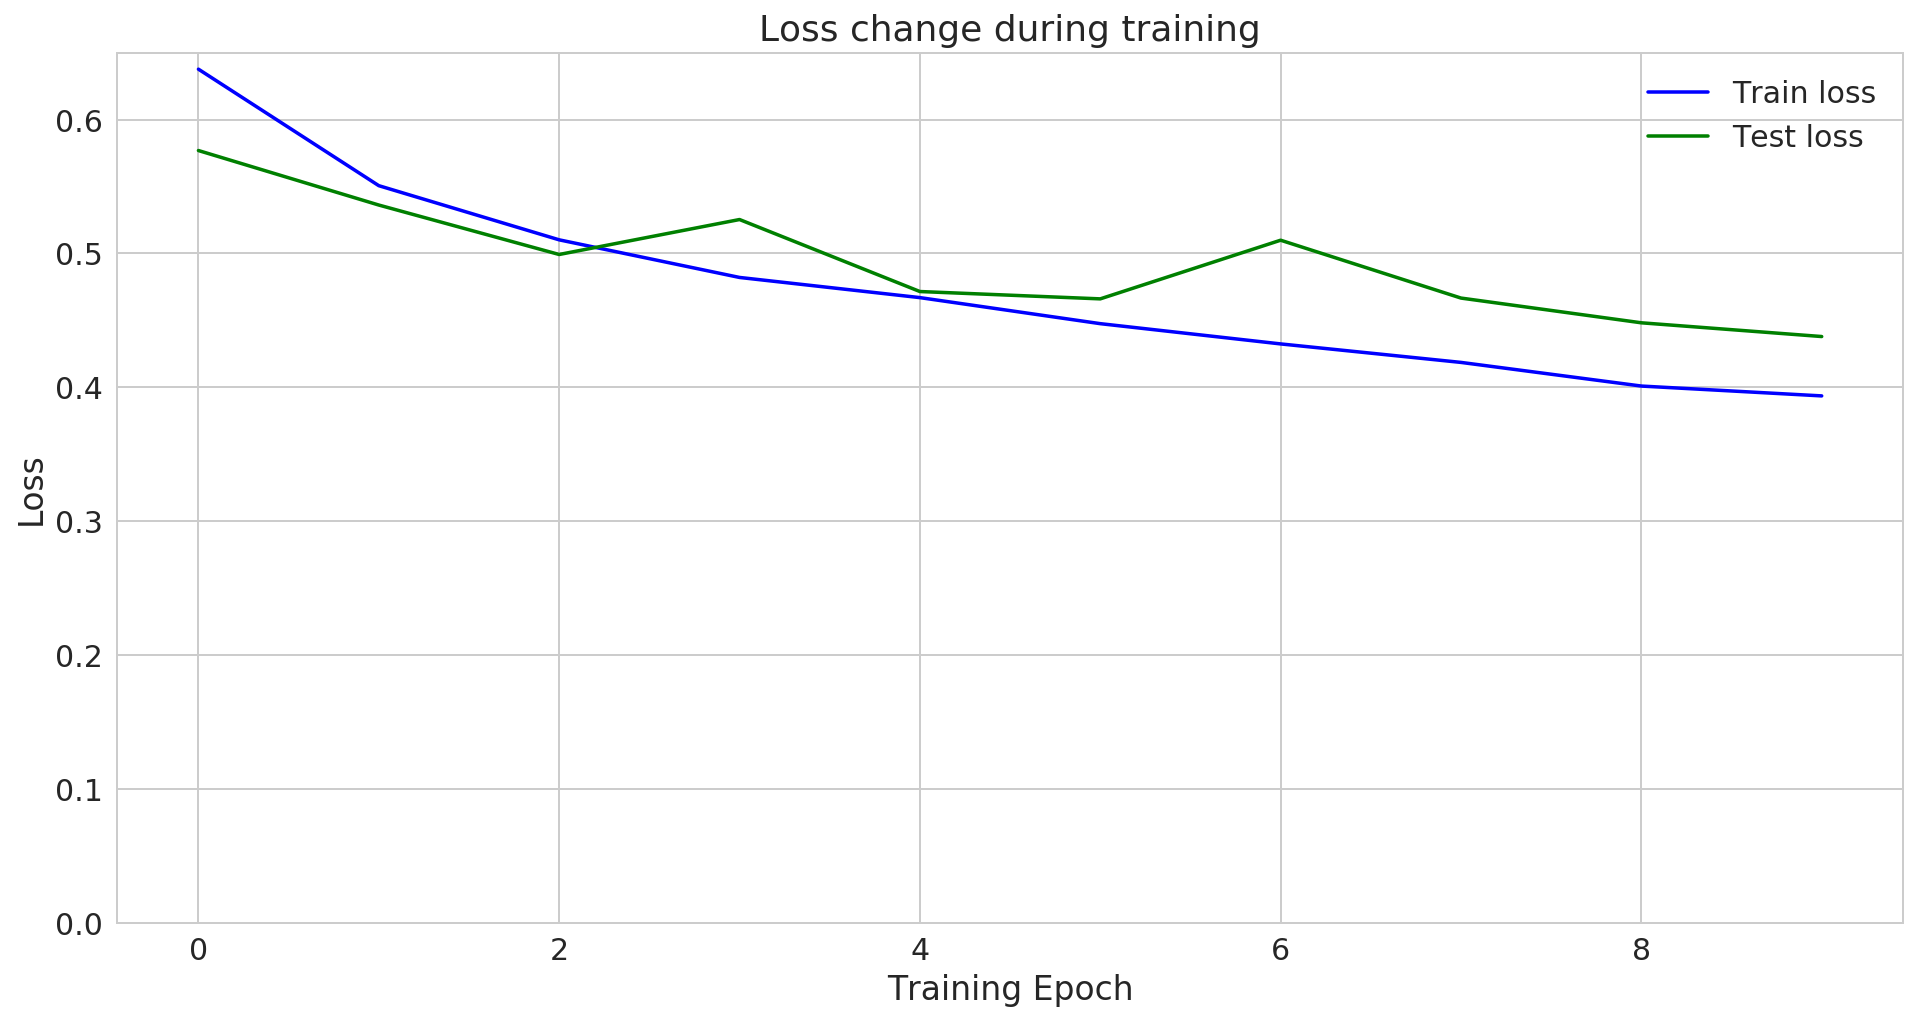

In [78]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, "b", label="Train loss")

plt.plot(test_loss, "g", label="Test loss")

plt.title("Loss change during training")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show();

In [0]:
model.eval()

ys = []
y_hats = []

for data, target in test_loader:
    data= Variable(data, volatile=True)
    
    if torch.cuda.is_available():
        data = data.cuda()
    
    output = model(data)

    pred = output.data.max(1, keepdim=True)[1]
    
    if torch.cuda.is_available():
        pred = pred.cpu()
    
    pred = pred.numpy().flatten()
    
    y_hats.extend(pred)
    ys.extend(target)

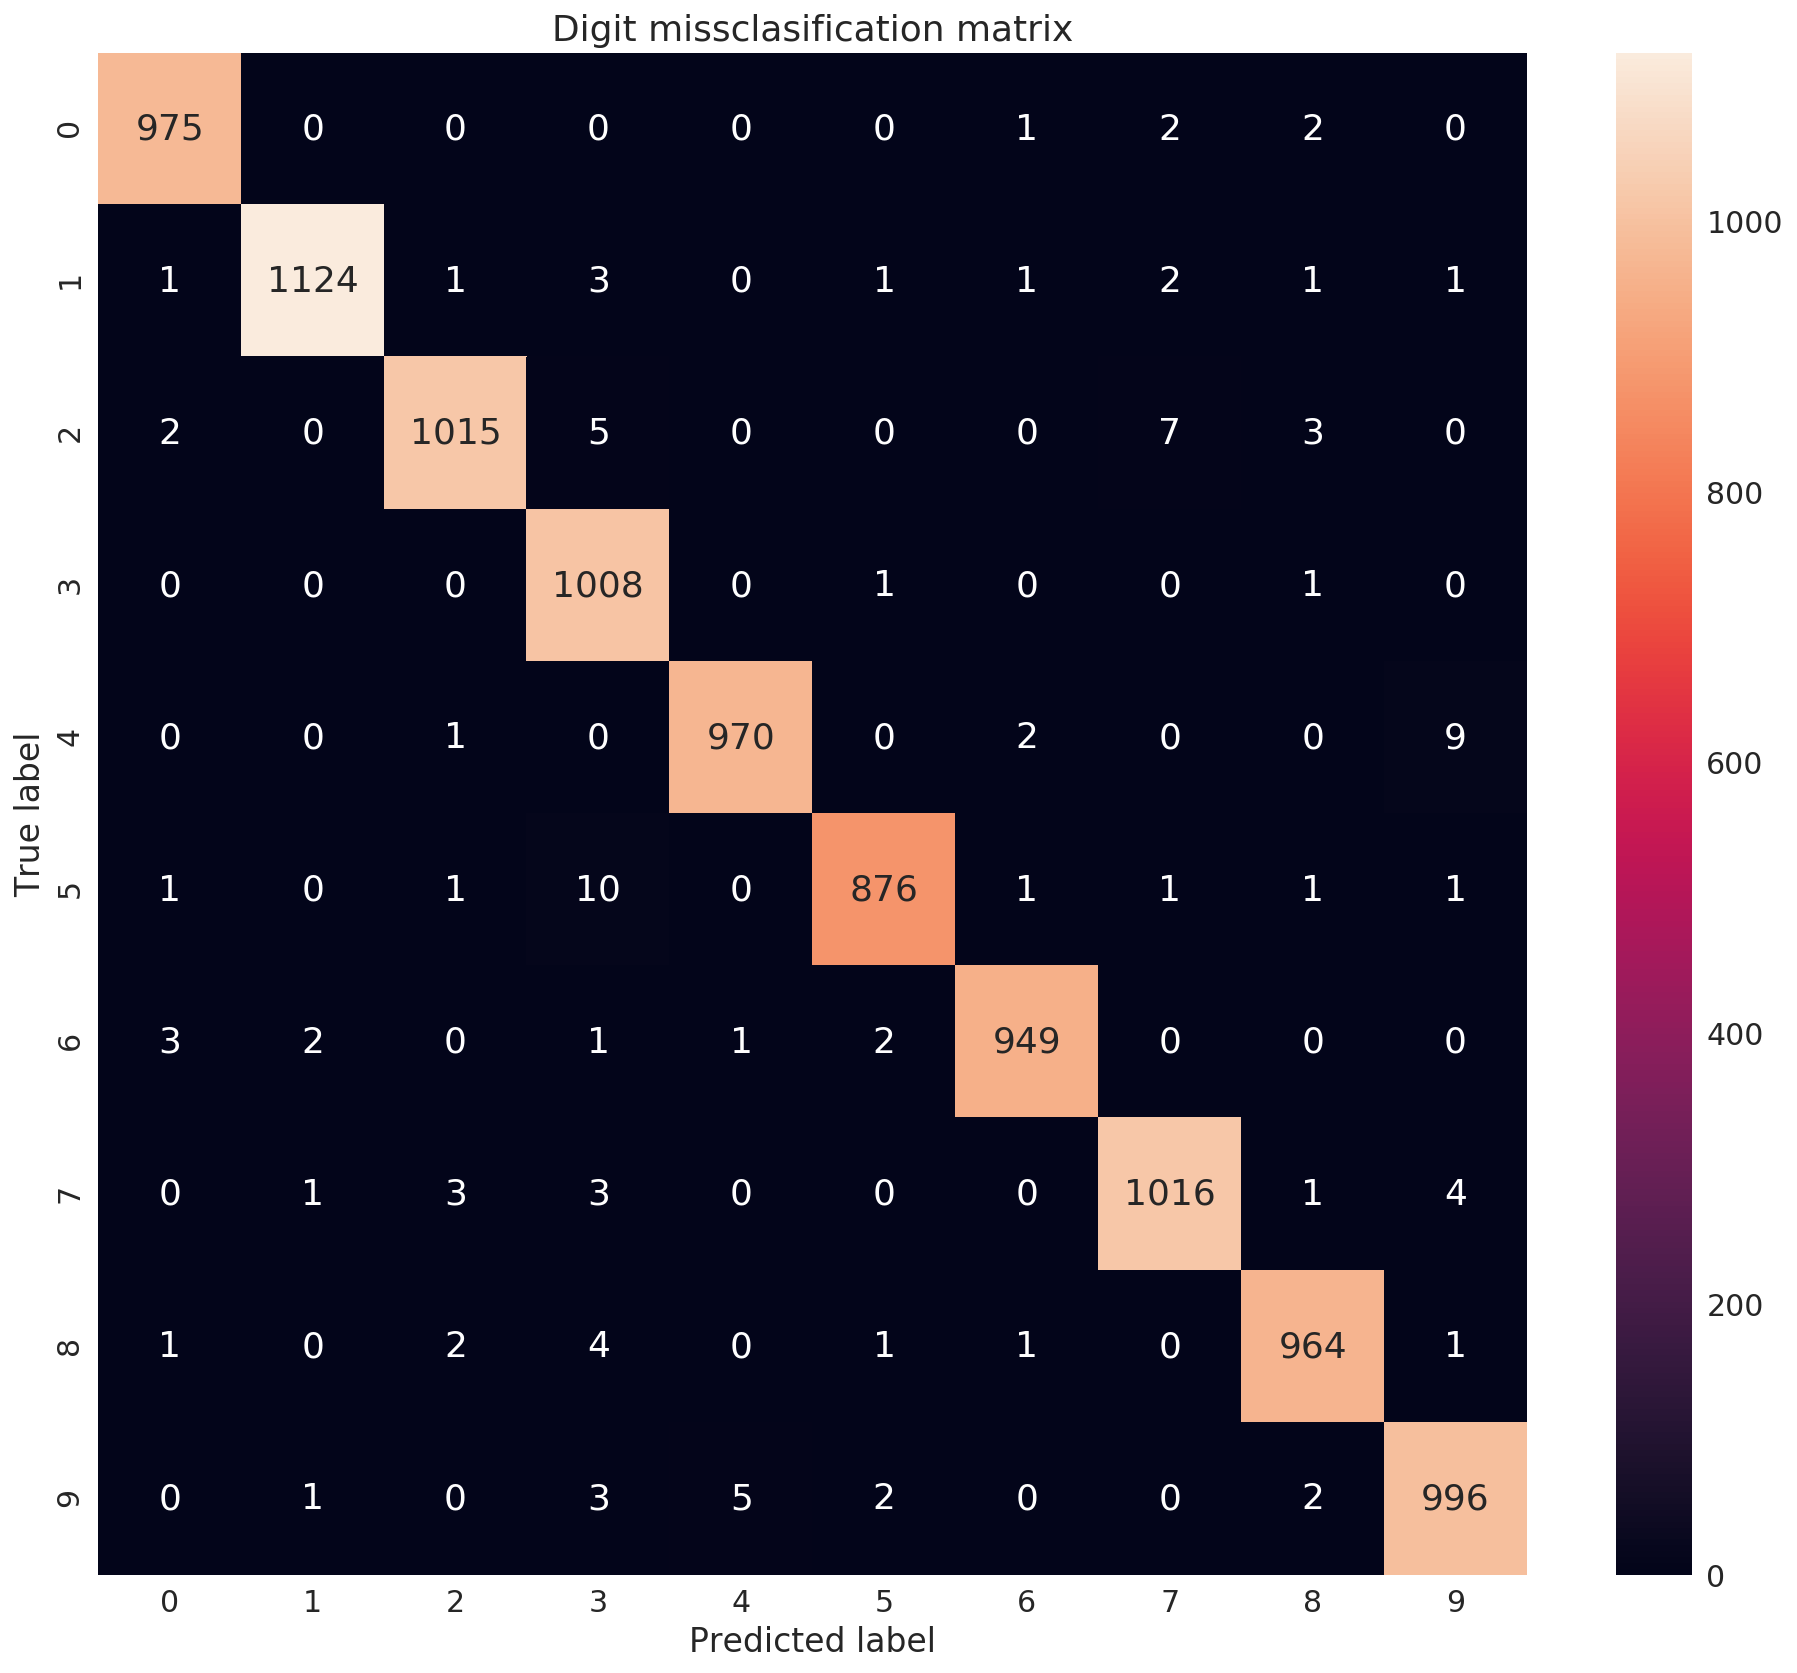

In [0]:
confusion_matrix = metrics.confusion_matrix(ys, y_hats)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Digit missclasification matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();